In [2]:
import json
import datetime

import matplotlib.pyplot as plt
import pandas as pd

In [3]:
with open("/home/jegkocka88/CCL/SO_Post_Analyzer/data/results/first_indiv") as handle:
    indiv_raw = json.load(handle)
    indiv = {k: datetime.datetime.strptime(v, '%Y-%m-%d') for k, v in indiv_raw.items()}

with open("/home/jegkocka88/CCL/SO_Post_Analyzer/data/results/first_pairs") as handle:
    pair_raw = json.load(handle)
    pair = {k: datetime.datetime.strptime(v, '%Y-%m-%d') for k, v in pair_raw.items()}

In [4]:
df_indiv = pd.DataFrame.from_dict(indiv, orient='index', columns=['appearance_date'])
df_pair = pd.DataFrame.from_dict(pair, orient='index', columns=['appearance_date'])

In [5]:
df_indiv['bin'] = pd.cut(df_indiv.appearance_date, bins=500)
df_indiv

,appearance_date,bin
MySQLdb,2008-08-03,"(2008-07-28 09:40:19.200000, 2008-08-14 04:39:..."
foo,2008-08-06,"(2008-07-28 09:40:19.200000, 2008-08-14 04:39:..."
new,2008-08-14,"(2008-07-28 09:40:19.200000, 2008-08-14 04:39:..."
setuptools,2008-08-20,"(2008-08-14 04:39:21.600000, 2008-08-25 09:18:..."
ctypes,2008-08-21,"(2008-08-14 04:39:21.600000, 2008-08-25 09:18:..."
...,...,...
win11toast,2023-11-27,"(2023-11-18 19:20:38.400000, 2023-11-30 00:00:00]"
freqtrade,2023-11-28,"(2023-11-18 19:20:38.400000, 2023-11-30 00:00:00]"
pyfixest,2023-11-28,"(2023-11-18 19:20:38.400000, 2023-11-30 00:00:00]"
yeelight,2023-11-29,"(2023-11-18 19:20:38.400000, 2023-11-30 00:00:00]"


In [9]:
df_pair['bin'] = pd.cut(df_pair.appearance_date, bins=500)
df_pair

,appearance_date,bin
parameterized|unittest,2008-08-28,"(2008-08-22 10:13:26.400000, 2008-09-08 03:33:..."
google|wsgiref,2008-09-16,"(2008-09-08 03:33:07.200000, 2008-09-19 07:06:..."
HTMLParser|html,2008-09-16,"(2008-09-08 03:33:07.200000, 2008-09-19 07:06:..."
dir|something,2008-09-23,"(2008-09-19 07:06:14.400000, 2008-09-30 10:39:..."
decorator|functools,2008-09-29,"(2008-09-19 07:06:14.400000, 2008-09-30 10:39:..."
...,...,...
psycopg|table,2023-11-29,"(2023-11-20 20:26:52.800000, 2023-12-02 00:00:00]"
sqlmodel|typer,2023-11-30,"(2023-11-20 20:26:52.800000, 2023-12-02 00:00:00]"
langchain|requests,2023-12-01,"(2023-11-20 20:26:52.800000, 2023-12-02 00:00:00]"
requests|seleniumbase,2023-12-02,"(2023-11-20 20:26:52.800000, 2023-12-02 00:00:00]"


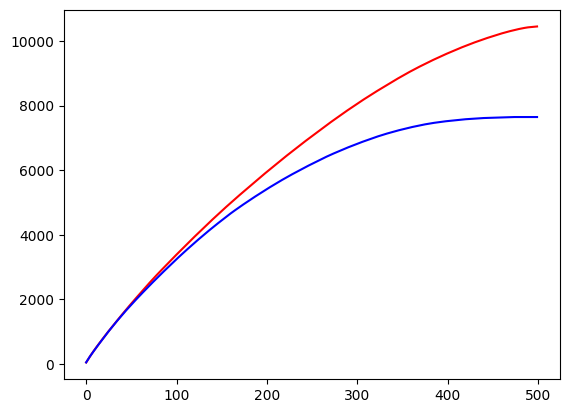

In [10]:
items = list(df_indiv.bin.value_counts())
sm = 0
cumulative_indiv = []
for item in items:
    sm += item
    cumulative_indiv.append(sm)

items = list(df_pair.bin.value_counts())
sm = 0
cumulative_pair = []
for item in items:
    sm += item
    cumulative_pair.append(sm)

plt.plot(range(len(cumulative_indiv)), cumulative_indiv, 'r-', range(len(cumulative_pair)), cumulative_pair, 'b-')

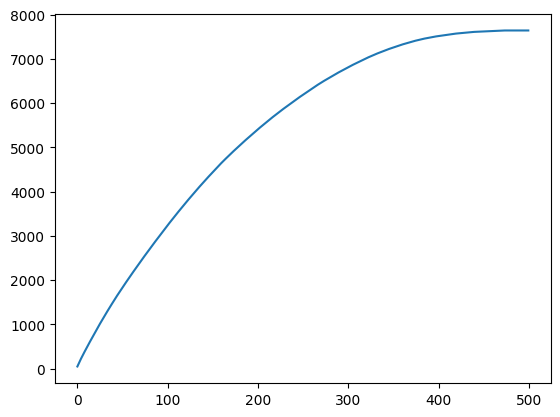

In [9]:


plt.plot(range(len(cumulative)), cumulative)